# Notebook 2 — Regresión Lineal con datos de accidentes y seguros

**Objetivo de la sesión (≈ 1 hora)**  
Entrenar un primer modelo de **regresión lineal** para predecir **primas de seguro de auto** usando información de accidentes, y entender:

- Cómo separar datos en **train / test**.  
- Cómo entrenar `LinearRegression` de `scikit-learn`.  
- Cómo evaluar el modelo con **MAE, RMSE, R²**.  
- Cómo analizar **residuales** y **coeficientes** (variables más influyentes).

Dataset (columnas utilizadas):

- `State`  
- `Number of drivers involved in fatal collisions per billion miles`  
- `Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding`  
- `Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired`  
- `Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted`  
- `Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents`  
- `Car Insurance Premiums ($)`  
- `Losses incurred by insurance companies for collisions per insured driver ($)`


In [2]:
# ==========================
# 0. Importar librerías
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)


## 1. Cargar el dataset crudo

En esta celda cargamos el archivo CSV original **sin modificaciones previas**.

> 👉 Ajusta la ruta al archivo según dónde lo tengas guardado (por ejemplo: `"bad-drivers.csv"` o `"data/bad-drivers.csv"`).


In [3]:
# ==========================
# 1. Cargar datos crudos
# ==========================
DATA_PATH = "bad-drivers.csv"  # <-- AJUSTAR si el archivo está en otra carpeta

df_raw = pd.read_csv(DATA_PATH)

# Ver primeras filas para confirmar estructura
df_raw.head()


,State,Number of drivers involved in fatal collisions per billion miles,Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding,Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired,Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted,Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents,Car Insurance Premiums ($),Losses incurred by insurance companies for collisions per insured driver ($)
0,Alabama,18.8,39,30,96,80,784.55,145.08
1,Alaska,18.1,41,25,90,94,1053.48,133.93
2,Arizona,18.6,35,28,84,96,899.47,110.35
3,Arkansas,22.4,18,26,94,95,827.34,142.39
4,California,12.0,35,28,91,89,878.41,165.63


**Tarea rápida (2 minutos)**  
- Verifica que todas las columnas mencionadas estén presentes.  
- Observa si hay valores raros (NaN, strings inesperados, etc.).

---

## 2. Inspección general del dataset

Antes de modelar, necesitamos entender:

- Tipos de datos.  
- Valores faltantes.  
- Rangos de las variables numéricas.


In [4]:
# Información general del dataset crudo
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 8 columns):
 #   Column                                                                                                  Non-Null Count  Dtype  
---  ------                                                                                                  --------------  -----  
 0   State                                                                                                   51 non-null     object 
 1   Number of drivers involved in fatal collisions per billion miles                                        51 non-null     float64
 2   Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding                                    51 non-null     int64  
 3   Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired                            51 non-null     int64  
 4   Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted                     

In [5]:
# Estadísticas descriptivas de las variables numéricas
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Number of drivers involved in fatal collisions per billion miles,51.0,15.790196,4.122002,5.90,12.750,15.60,18.500,23.90
Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding,51.0,31.725490,9.633438,13.00,23.000,34.00,38.000,54.00
Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired,51.0,30.686275,5.132213,16.00,28.000,30.00,33.000,44.00
Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted,51.0,85.921569,15.158949,10.00,83.000,88.00,95.000,100.00
Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents,51.0,88.725490,6.960110,76.00,83.500,88.00,95.000,100.00
Car Insurance Premiums ($),51.0,886.957647,178.296285,641.96,768.430,858.97,1007.945,1301.52
Losses incurred by insurance companies for collisions per insured driver ($),51.0,134.493137,24.835922,82.75,114.645,136.05,151.870,194.78


**Preguntas para comentar en grupo (rápido):**

1. ¿Hay valores faltantes en alguna columna relevante?  
2. ¿Alguna variable tiene un rango muy distinto a las demás (por ejemplo, más grande por varias órdenes de magnitud)?  
3. ¿Cuál podría ser una buena **variable objetivo** (y) para un modelo de regresión?

En este notebook asumiremos que queremos **predecir la prima de seguro**:

> 🎯 `y = Car Insurance Premiums ($)`

## 3. Selección de variables para el modelo

Vamos a construir un modelo sencillo que prediga:
- `Car Insurance Premiums ($)` (variable objetivo)

Usando como **features**:

- `Number of drivers involved in fatal collisions per billion miles`
- `Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding`
- `Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired`
- `Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted`
- `Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents`
- `Losses incurred by insurance companies for collisions per insured driver ($)`

La columna `State` la dejaremos fuera del primer modelo (es categórica y requeriría codificación adicional).


In [6]:
# ==========================
# 3. Seleccionar X (features) e y (target)
# ==========================

target_col = "Car Insurance Premiums ($)"

feature_cols = [
    "Number of drivers involved in fatal collisions per billion miles",
    "Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding",
    "Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired",
    "Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted",
    "Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents",
    "Losses incurred by insurance companies for collisions per insured driver ($)"
]

# Nos quedamos solo con las columnas necesarias
df_model = df_raw[feature_cols + [target_col]].copy()

# Por simplicidad, eliminamos filas con NaN en estas columnas
df_model = df_model.dropna()

print(df_model.shape)
df_model.head()


(51, 7)


,Number of drivers involved in fatal collisions per billion miles,Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding,Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired,Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted,Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents,Losses incurred by insurance companies for collisions per insured driver ($),Car Insurance Premiums ($)
0,18.8,39,30,96,80,145.08,784.55
1,18.1,41,25,90,94,133.93,1053.48
2,18.6,35,28,84,96,110.35,899.47
3,22.4,18,26,94,95,142.39,827.34
4,12.0,35,28,91,89,165.63,878.41


## 4. Separar en entrenamiento y prueba (train / test split)

Usaremos:

- **X**: matriz de features.  
- **y**: vector de primas de seguro.  
- 80% de los datos para **entrenar** y 20% para **probar** el modelo.

Usaremos `random_state` fijo para reproducibilidad.


In [7]:
# ==========================
# 4. Train / Test Split
# ==========================

X = df_model[feature_cols]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((40, 6), (11, 6))

**Chequeo rápido:**

- ¿Cuántos registros quedaron para entrenamiento y cuántos para prueba?  
- ¿Ves algún desbalance evidente (muchos pocos datos)?

---

## 5. Entrenar el modelo de Regresión Lineal

Usaremos `LinearRegression()` de `scikit-learn`:

- Ajusta un modelo lineal de la forma  
  \\( \hat{y} = \beta_0 + \beta_1 x_1 + \dots + \beta_p x_p \\).


In [8]:
# ==========================
# 5. Entrenar modelo LinearRegression
# ==========================

linreg = LinearRegression()
linreg.fit(X_train, y_train)

print("Intercepto (beta_0):", linreg.intercept_)
print("\nCoeficientes:")
for col, coef in zip(feature_cols, linreg.coef_):
    print(f"{col}: {coef:.4f}")


Intercepto (beta_0): -606.034214910964

Coeficientes:
Number of drivers involved in fatal collisions per billion miles: -9.2426
Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding: 1.7854
Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired: 5.7412
Percentage Of Drivers Involved In Fatal Collisions Who Were Not Distracted: 1.3617
Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents: 8.2672
Losses incurred by insurance companies for collisions per insured driver ($): 4.0329


**Interpretación rápida de coeficientes (en plenario):**

- El intercepto es el valor de la prima de seguro cuando todas las variables explicativas valen 0 (aquí tiene menos interpretación directa, pero es parte del modelo).  
- Cada coeficiente indica cómo cambia la **prima de seguro (en dólares)** cuando la variable correspondiente aumenta en 1 unidad, manteniendo las demás constantes.

---

## 6. Predicción y análisis de residuales

Ahora vamos a:

1. Obtener predicciones en el **conjunto de prueba**.  
2. Calcular **residuales**:  
   \\( \text{residual} = y_{\text{real}} - y_{\text{predicho}} \\).  
3. Graficar:
   - `y_test` vs `y_pred` (dispersión).  
   - Residuales vs `y_pred`.  
   - Histograma de residuales.


In [9]:
# ==========================
# 6. Predicciones en el set de prueba
# ==========================

y_pred = linreg.predict(X_test)

# Creamos un DataFrame auxiliar para análisis
df_results = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": y_pred
})
df_results["residual"] = df_results["y_test"] - df_results["y_pred"]

df_results.head()


,y_test,y_pred,residual
0,1004.75,979.885008,24.864992
1,858.97,745.655574,113.314426
2,768.95,931.442184,-162.492184
3,641.96,742.976824,-101.016824
4,896.07,904.600735,-8.530735


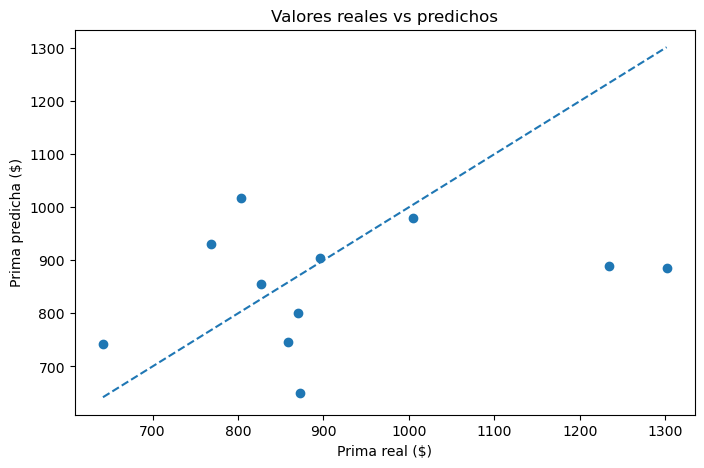

In [10]:
# Dispersión: valores reales vs predichos
plt.figure()
plt.scatter(df_results["y_test"], df_results["y_pred"])
plt.xlabel("Prima real ($)")
plt.ylabel("Prima predicha ($)")
plt.title("Valores reales vs predichos")
plt.plot(
    [df_results["y_test"].min(), df_results["y_test"].max()],
    [df_results["y_test"].min(), df_results["y_test"].max()],
    linestyle="--"
)
plt.show()


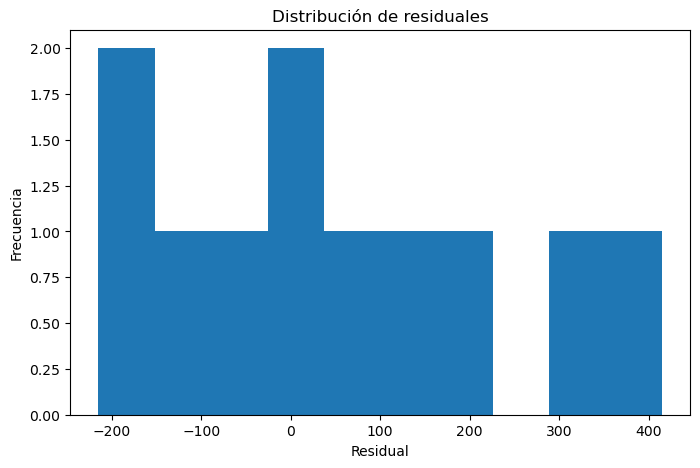

In [11]:
# Histograma de residuales
plt.figure()
plt.hist(df_results["residual"], bins=10)
plt.xlabel("Residual")
plt.ylabel("Frecuencia")
plt.title("Distribución de residuales")
plt.show()


**Preguntas de análisis (para comentario rápido):**

- ¿Los puntos en `y_real vs y_pred` se acercan a la diagonal?  
- ¿Los residuales parecen estar centrados alrededor de 0?  
- ¿Ves patrones claros (curvas, abanicos) en la gráfica de residuales vs predicción?  
  - Si hay patrones fuertes, podría indicar que el modelo lineal es insuficiente.

---

## 7. Métricas de desempeño: MAE, RMSE, R²

Vamos a calcular tres métricas clave:

- **MAE** (Mean Absolute Error): error medio absoluto.  
- **RMSE** (Root Mean Squared Error): error cuadrático medio en escala original.  
- **R²**: proporción de varianza explicada por el modelo (entre 0 y 1, aunque puede ser negativa si el modelo es muy malo).


In [12]:
# ==========================
# 7. Cálculo de métricas
# ==========================

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")


MAE : 154.95
RMSE: 200.52
R²  : -0.155


**Interpretación:**

- **MAE** y **RMSE** están en **dólares**, por lo que se pueden comparar directamente con la magnitud típica de la prima.  
- **R²** cerca de 1 indica que el modelo explica bien la variabilidad; cerca de 0 indica bajo poder explicativo.

Discute con tu grupo:
- Dado el rango de `Car Insurance Premiums ($)`, ¿estos errores son razonables?  
- ¿El R² parece aceptable para un primer modelo simple?

---

## 8. Variable más influyente (coeficientes)

Vamos a ordenar los coeficientes del modelo según su valor absoluto para ver qué variables tienen mayor impacto en la prima de seguro (bajo el supuesto lineal del modelo).


In [13]:
# ==========================
# 8. Análisis de importancia de variables
# ==========================

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": linreg.coef_
})
coef_df["abs_coef"] = coef_df["coef"].abs()

coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)
coef_df_sorted


,feature,coef,abs_coef
0,Number of drivers involved in fatal collisions...,-9.242649,9.242649
4,Percentage Of Drivers Involved In Fatal Collis...,8.267206,8.267206
2,Percentage Of Drivers Involved In Fatal Collis...,5.741162,5.741162
5,Losses incurred by insurance companies for col...,4.032939,4.032939
1,Percentage Of Drivers Involved In Fatal Collis...,1.785421,1.785421
3,Percentage Of Drivers Involved In Fatal Collis...,1.361681,1.361681


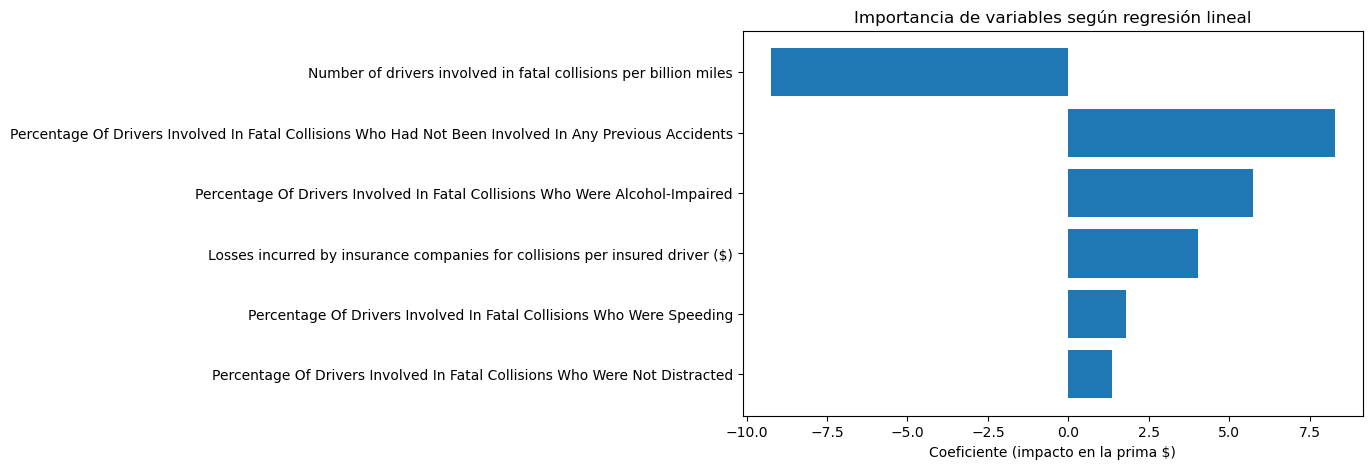

In [14]:
# Gráfico de barras de la magnitud de los coeficientes
plt.figure()
plt.barh(coef_df_sorted["feature"], coef_df_sorted["coef"])
plt.xlabel("Coeficiente (impacto en la prima $)")
plt.title("Importancia de variables según regresión lineal")
plt.gca().invert_yaxis()  # la más importante arriba
plt.show()


**Mini-desafío (para 5–10 minutos):**

En tu grupo, respondan:

1. ¿Cuál es la **variable más influyente** según la magnitud del coeficiente?  
2. ¿El signo del coeficiente (positivo/negativo) tiene sentido con la intuición del problema?  
3. Usando tanto la tabla de coeficientes como las gráficas de residuales:  
   - ¿Creen que este modelo lineal captura bien la relación entre variables?  
   - ¿Qué mejoraría para una siguiente versión (más features, transformaciones, modelos no lineales, etc.)?

---

## 9. Cierre del Notebook 2

En este notebook aprendimos a:

- Partir desde el **dataset crudo**.  
- Seleccionar una **variable objetivo** y un subconjunto de **features**.  
- Dividir en **train/test**.  
- Entrenar un modelo de **regresión lineal** con `scikit-learn`.  
- Evaluar el desempeño con **MAE, RMSE, R²**.  
- Analizar **residuales** y **coeficientes** para entender el comportamiento del modelo.

En el siguiente paso, pueden:
- Probar diferentes combinaciones de features.  
- Agregar transformaciones (por ejemplo, escalar, log-transform).  
- Comparar con otros modelos de regresión más avanzados.

> Dejen guardado este notebook, porque será la base para conectarlo con otras sesiones del curso (por ejemplo, comparación con modelos más complejos o incorporación de nuevas variables).
